# Машинное обучение для прогнозирования временных рядов: фреймворк sktime

## Введение 

Для Python существует множество пакетов для анализа данных и построения предиктивных моделей. Концептуально они относятся к двум категориям. К первой относятся пакеты для работы с данными временных рядов:
![](https://www.sktime.net/en/stable/_images/forecasting.png)

Примеры таких пакетов:
![](https://www.sktime.net/en/stable/_images/ts-fragmentation.png)

Пакеты из второй категории предназначены для работы с кросс-секционными данными. Самый известный пакет этого типа - sklearn.
![](https://www.sktime.net/en/stable/_images/sklearn-unified-interface.jpg)

В sklearn интегрировано множество алгоритмов прогнозирования и их объединяет одинаковый интерфейс - создание модели (estimator), обучение модели (.fit()) и прогнозирование (.predict()). Есть возможность строить конвейеры для обработки данных, включающие преобразование данных, оценку и выбор модели, разработку прогноза.

Но sklearn разрабатывался для кросс-секционных данных, т.е. таблиц, в которых нет хронологической упорядочености наблюдений. Это приводит к сложностям при валидации моделей (train_test_split() не учитывает хронологическую упорядоченность, что приводит к утечкам данных) и при использовании авторегрессионных моделей, для которых необходимо преобразовывать данные с помощью скользящего окна для обучения модели, а также применять модель последовательно в течение нескольких шагов, чтобы получить прогноз. Это не поддерживается из коробки, поэтому приходится писать много дополнительного кода.
![](https://www.sktime.net/en/stable/_images/sktime-interoperable.png)
Фреймворк [sktime](https://github.com/sktime/sktime) разработан чтобы с временными рядами (одномерными и многомерными) можно было работать через единообразный интерфейс, подобный sklearn. Фреймворк позволяет решать множество задач, но мы в этом блокноте остановимся на примерах применения его для прогнозирования.

С концепцией пакета sktime можно познакомиться в [мастер-классе авторов пакета](https://www.youtube.com/watch?v=ODspi8-uWgo&list=PLKs3UgGjlWHqNzu0LEOeLKvnjvvest2d0&index=5) и в [документации](https://www.sktime.net/en/stable/examples.html).

## Подготовка данных

Исходные данные для прогнозирования должны быть в формате pandas DataFrame или Series с временными периодами в качеств индекса ([PeriodIndex](https://docs-python.ru/packages/modul-pandas-analiz-dannykh-python/period-periodindex/))

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns # Визуализация
import matplotlib.pyplot as plt # Визуализация
# Графики встраиваются в блокнот:
%matplotlib inline
sns.set() # Стиль графиков

In [2]:
catalog = pd.read_excel('catalog.xlsx', # файл с данными
                       index_col='date')  # столбец 'date' нужно использовать как индекс

catalog.index = catalog.index.to_period(freq='M') # Важно изменить тип индекса на PeriodIndex, иначе ничего не будет работать
catalog

,men,women,jewel,mail,page,phone,printadv,service
date,,,,,,,,
1989-01,11357.92,16578.93,10776.38,7978,73,34,22294.48,20
1989-02,10605.95,18236.13,10821.97,8290,88,29,27426.47,20
1989-03,16998.57,43393.55,22845.79,8029,65,24,27978.66,26
1989-04,6563.75,30908.49,11102.62,7752,85,20,28949.65,22
1989-05,6607.69,28701.58,16066.57,8685,74,17,22642.27,21
...,...,...,...,...,...,...,...,...
1998-08,30208.17,58660.76,24377.91,11808,85,44,26668.16,45
1998-09,24467.94,57791.14,16044.00,12781,83,49,29911.68,54
1998-10,23602.00,56329.40,15974.66,11690,95,43,27872.97,55


Данные - ежемесячные. В таблице присутствуют значения оборота по трем товарным категориям - мужская одежда, женская одежда и украшения, а также сопутствующие факторы. 

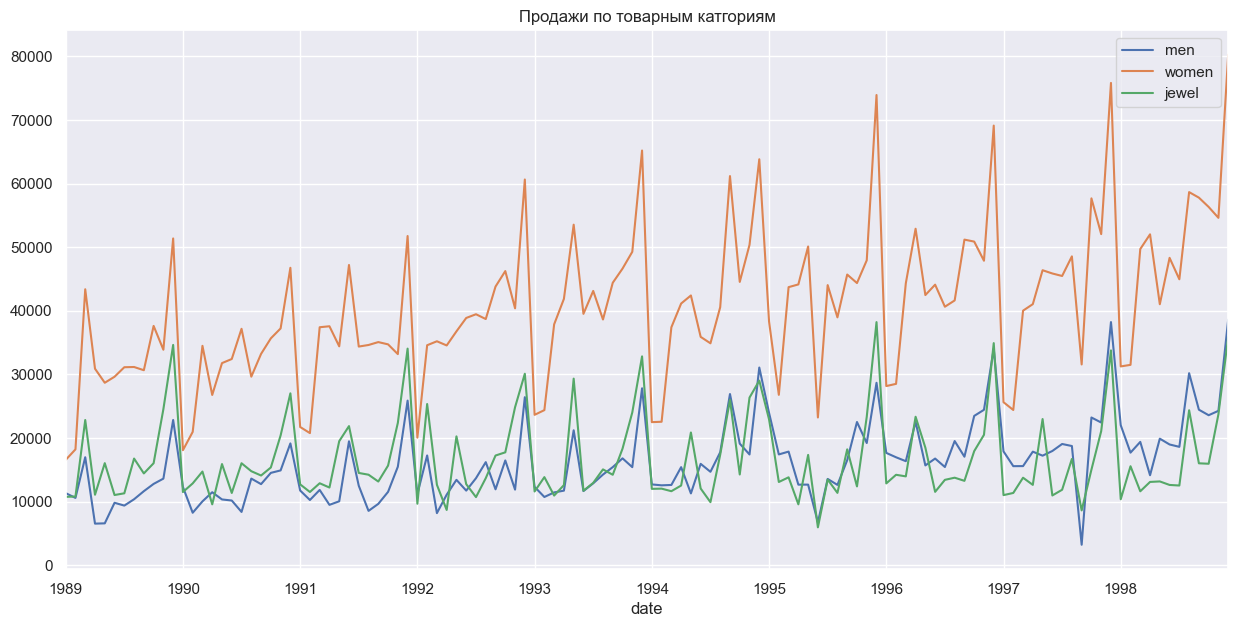

In [3]:
catalog.iloc[:, :3].plot(figsize=(15,7), title='Продажи по товарным катгориям')
plt.show()

Для примера будем прогнозировать ряд продаж по категории женской одежды (`women`). Разделим его на обучающий и тестовый периоды. В качестве тестового периода будем использовать последние 12 месяцев.

In [4]:
from sktime.forecasting.model_selection import temporal_train_test_split

Пакет sktime по умолчанию не установлен в Anaconda. [Здесь](https://www.sktime.net/en/latest/installation.html#) описано, как его установить - с помощью `conda` или `pip`.

In [5]:
w = catalog['women']

In [6]:
w_train, w_test = temporal_train_test_split(w, test_size=12)

В данном случае обучающие и тестовые данные - ряды pandas

In [7]:
type(w_train)

pandas.core.series.Series

Индексом ряда являются временные периоды с месячной частотой.

In [8]:
w_train.index

PeriodIndex(['1989-01', '1989-02', '1989-03', '1989-04', '1989-05', '1989-06',
             '1989-07', '1989-08', '1989-09', '1989-10',
             ...
             '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08',
             '1997-09', '1997-10', '1997-11', '1997-12'],
            dtype='period[M]', name='date', length=108)

## Модели временных рядов в sktime

Прогнозирование в sktime всегда использует унифицированный интерфейс и включает 4 шага:
 - Импорт класса модели
 - Выбор горизонта прогнозирования
 - Обучение модели
 - Построение прогноза (точечного или интервального)

### Наивный прогноз

"Наивный" прогноз - это простейший подходв в прогнозировании, основанный на предположении, что "завтра будет так же, как и вчера". Мы можем повторять последние значения (или прошлогодние значения для сезонного ряда) и использовать их в качестве прогноза.

**Шаг 1 - импорт класса модели и создание модели**
Здесь мы используем одина из наиболее простых алгоритмов - наивный прогноз. Он используется в качестве базы для сравнения эффективности других алгоритмов прогнозирования.

Всего же в sktime интегрировано несколько десятков [различных алгоритмов](https://www.sktime.net/en/latest/estimator_overview.html). 

In [9]:
from sktime.forecasting.naive import NaiveForecaster


In [10]:
forecaster = NaiveForecaster(strategy="last", sp=12) # Необученная модель в переменной forecaster. sp - длина сезонного цикла

Так можно посмотреть описание параметров модели:

In [11]:
#NaiveForecaster?

**Шаг 2 - выбор гориознта прогнозирования**
Некоторые алгоритмы требуют указывать горизонт прогнозирования уже при обучении модели, поэтому вначале определим этот горизонт.

Существует два подхода: 

- использовать массив numpy с номерами периодов.

In [12]:
fh = np.arange(1, 13)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

 - использовать класс [`ForecastingHorizon`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.base.ForecastingHorizon.html) из sktime

В этом случае можно использовать массивы numpy или индексы pandas для определения периода. Горизонт может быть абсолютным (конкретные периоды) или относительным (отсчитывается от конца обучающего периода)

In [13]:
from sktime.forecasting.base import ForecastingHorizon

fh_dates = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1998-01-01", periods=12, freq="ME")), 
    is_relative=False
)
fh_dates

ForecastingHorizon(['1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06',
             '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12'],
            dtype='period[M]', is_relative=False)

Для сравнения моделей на тестовом периоде удобно использовать индекс тестового периодра:

In [14]:
fh = ForecastingHorizon(w_test.index)
fh # Горизонт прогнозирования - индекс ряда с тестовыми данными

ForecastingHorizon(['1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06',
             '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12'],
            dtype='period[M]', name='date', is_relative=False)

**Шаг 3 - обучение модели**

In [15]:
forecaster.fit(w_train)

NaiveForecaster(sp=12)

**Шаг 4 - прогнозирование**

Точечный прогноз можно получить с помощью метода `.predict()`. Некоторые алгоритмы поддерживают также и построение интервального прогноза с заданной доверительной вероятностью. Интервальный прогноз можно получить с помощью метода `.predict_interval()`. Результат точечного прогноза - ряд pandas, а интервальный прогноз возвращается в виде таблицы pandas с нижней и верхней границей интервала.

In [16]:
w_f_naive = forecaster.predict(fh)
w_pi_naive = forecaster.predict_interval(coverage=0.9)

In [17]:
from sktime.utils.plotting import plot_series

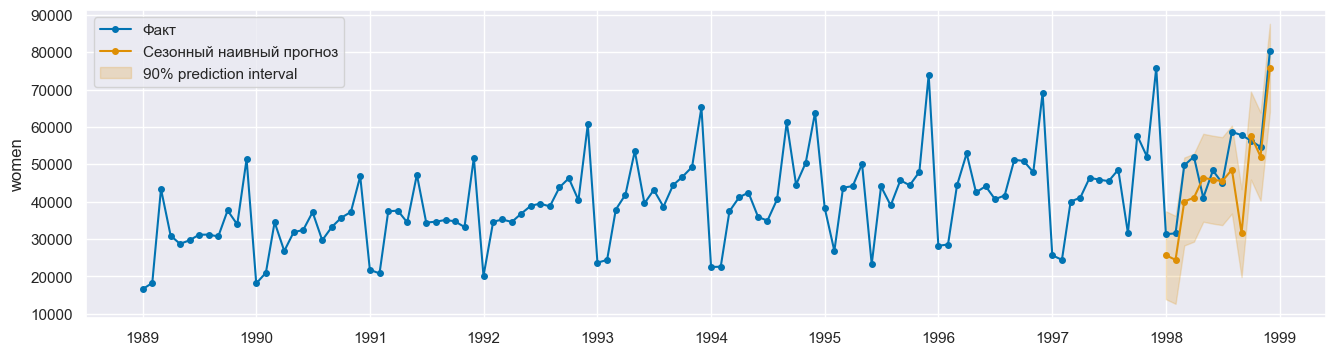

In [18]:
plot_series(w, w_f_naive, 
            labels=['Факт', 'Сезонный наивный прогноз'],
            pred_interval=w_pi_naive)
plt.show()

Для сравнения моделей используем несколько показателей ошибки прогноза. В sktime есть популярный показатель MAPE, но нет некоторых других. Их возьмем из statsmodels.


In [19]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse, bias, meanabs

In [20]:
def metrics(model, actuals, forecast):
    """
    Возвращает таблицу с показателями ошибки прогноза
    """
    return pd.DataFrame({'model' : model, 
                         'mape' : mean_absolute_percentage_error(actuals, forecast),
                         'rmse' : rmse(actuals, forecast),
                         'bias' : bias(actuals, forecast)
                        }, index = [1])

In [21]:
w_metrics_naive = metrics('naive', w_test, w_f_naive)
w_metrics_naive

,model,mape,rmse,bias
1,naive,0.146223,9780.764538,5992.535833


### Экспоненциальное сглаживание

Попробуем мультипликативную модель Винтерса

**Шаг 1 - импорт класса модели и создание модели**

In [22]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="additive", seasonal="multiplicative", sp=12)

В этом варианте константы сглаживания и начальные значения компонентов определяются автоматически. Как их поменять вручную, можно узнать в справке:

In [23]:
#ExponentialSmoothing?

**Шаг 2 - выбор горизонта прогнозирования**

Используем тот же горизонт, что и для предыдущей модели - весь тестовый период.

In [24]:
fh

ForecastingHorizon(['1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06',
             '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12'],
            dtype='period[M]', name='date', is_relative=False)

**Шаг 3 - обучение модели**

In [25]:
forecaster.fit(w_train)

w:\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ExponentialSmoothing(seasonal='multiplicative', sp=12, trend='additive')

Предупреждение о сходимости оптимизации вызвано ошибкой в пакете statsmodels, его можно отключить так:

In [26]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

**Шаг 4 - прогнозирование**

In [27]:
w_f_winters_mult = forecaster.predict(fh)
#w_pi_winters_mult = forecaster.predict_interval(coverage=0.9) # пока не реализовано

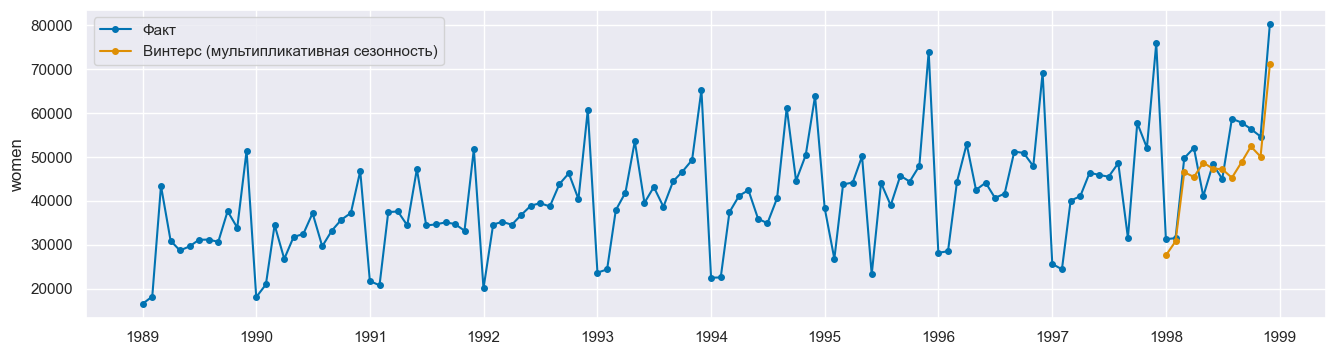

In [28]:
plot_series(w, w_f_winters_mult,
            labels=['Факт', 'Винтерс (мультипликативная сезонность)'],
            #pred_interval=w_pi_winters_mult
           )
plt.show()

In [29]:
w_metrics_winters_mult = metrics('Винтерс (мультипликативная сезонность)', w_test, w_f_winters_mult)
w_metrics_winters_mult

,model,mape,rmse,bias
1,Винтерс (мультипликативная сезонность),0.103493,6553.103354,3798.889652


### Модель ETS

**Шаг 1 - импорт класса модели**

In [30]:
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

**Шаг 2 - горизонт прогноза**

Используем тот же самый

**Шаг 3 - Обучение модели**

In [31]:
forecaster.fit(w_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [32]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  women   No. Observations:                  108
Model:                       ETS(MNM)   Log Likelihood               -1090.762
Date:                Thu, 19 Dec 2024   AIC                           2213.524
Time:                        09:29:43   BIC                           2256.438
Sample:                    01-31-1989   HQIC                          2230.924
                         - 12-31-1997   Scale                            0.024
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2643        nan        nan        nan         nan         nan
smoothing_seasonal   7.357e-05        nan        nan        nan         nan         nan
initial_level        3.173e+04        nan        nan        nan         nan         nan
initial_seasonal.0      2.3154        nan        nan        nan         nan         nan
initial_seasonal.1      1.6386        nan        nan        nan         nan         nan
initial_seasonal.2      1.6859        nan        nan        nan         nan         nan
initial_seasonal.3      1.6463        nan        nan        nan         nan         nan
initial_seasonal.4      1.4422        nan        nan        nan         nan         nan
initial_seasonal.5      1.5007        nan        nan        nan         nan         nan
initial_seasonal.6      1.5062        nan        nan        nan         nan         nan
initial_seasonal.7      1.5695        nan        nan        nan         nan         nan
initial_seasonal.8      1.4993        nan        nan        nan         nan         nan
initial_seasonal.9      1.5215        nan        nan        nan         nan         nan
initial_seasonal.10     1.0039        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       20.72   Jarque-Bera (JB):                45.85
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.24
Prob(H) (two-sided):                  0.77   Kurtosis:                         6.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

**Шаг 4 - Прогнозирование**

In [33]:
w_f_autoETS = forecaster.predict(fh)
w_pi_autoETS = forecaster.predict_interval(coverage=0.9)

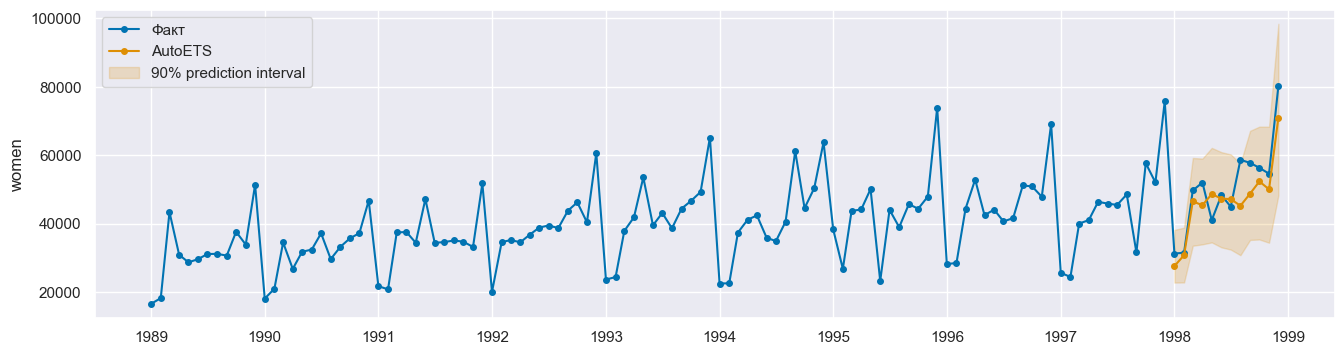

In [34]:
plot_series(w, w_f_winters_mult,
            labels=['Факт', 'AutoETS'],
            pred_interval=w_pi_autoETS
           )
plt.show()

In [35]:
w_metrics_autoETS = metrics('Auto ETS', w_test, w_f_autoETS)
w_metrics_autoETS

,model,mape,rmse,bias
1,Auto ETS,0.09377,6456.411862,3799.198346


# Прогнозирование с помощью моделей машинного обучения

Модели машинного обучения, такие как ансамбли деревьев (Random Forest, xgboost, LightGBM) показывают хорошие результаты при прогнозировании спроса. В исследовании [M4 Forecasting Competition](https://rpubs.com/fotpetr/m4competition) лушчие результаты показали модели ML и ансамбли ML и статистических моделей. Хотя в среднем улучшение показателей ошибки по сравнению с классическими методами у них небольшое, а вычислительные затраты значительно выше. Методы машинного обучения [оказались](https://www.sciencedirect.com/science/article/pii/S0169207021001874?via%3Dihub) наиболее полезны в ситуации массового прогнозирования при наличии информации о внешних факторах (промо, изменение цен, дефицит). 

Модели машинного обучения сложно применять к временным рядам, т.к. они разрабатывались для кросс-секционных данных - матрицы факторов и вектора значений целевой переменной. Порядок наблюдений в этой ситуации не важен, поэтому и методы разбиения на обучающее и тестовое множество с помощью кросс-валидации или случайного семплирования непригодны для временных рядов. Также у моделей как правило одна выходная переменная, т.е. они позволяют строить прогноз только на один период. Чтобы получить прогноз на год, нужно построить 12 моделей. Некоторые типы моделей (нейросетевые sequence-to-sequence) позволяют строить прогноз сразу на несколько периодов, но такие модели пока не очень распространены из-за большой вычислительной сложности.

## Авторегрессионные модели

При использовании авторегрессионных моделей для предсказания будущих значений используются только предыдущие значения временного ряда. Основные сложности при использовании этих моделей - подготовка данных для обучения и итеративное построение прогноза. Подготовка данных предполагает, что данные ряда обрабатываются скользящим окном, которое помещает в одну строку таблицы несколько прошлых значений (как правило, 12 или больше). Т.к. модель строит прогноз на один период, для получения прогноза на последующие периоды нужно несколько раз применять ее к данным, каждый раз дополняя их предыдущим прогнозом.
В sktime эти операции выполняются легко и в едином интерфейсе.

![](https://www.sktime.net/en/stable/_images/forecasting-to-regression-reduction.png)

**Шаг 1 - импорт класса модели и создание модели**

Для прогнозирования можно использовать различные виды ML-моделей, которые решают задачу регрессии (предсказания непрерывной целевой переменной). Такие модели реализованы в пакете sklearn, xgboost и других популярных пакетах. 

Чтобы адаптировать подобные модели к данным временного ряда, в sktime есть функция `make_reduction()`, которая обрабатывает данные скользящим окном и обучает на них модель. 

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

In [48]:
regressor = RandomForestRegressor(n_estimators=100, random_state=24)
forecaster = make_reduction(regressor, window_length=24, strategy="recursive") # Модель обучается на 24 предыдущих месяцах

Поддерживаются несколько стратегий моделирования, в т.ч. recursive (последовательная: обучается одна модель, делающая прогноз на 1 шаг, затем она рекурсивно применяется к данным, с дополнением данных прогнозом с предыдущего шага) и direct (параллельная: обучается несколько моделей, каждая на свой горизонт)

In [49]:
#make_reduction?

**Шаг 2 - горизонт прогноза**

Используем тот же самый.

**Шаг 3 - обучение модели**

In [50]:
forecaster.fit(w_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=24),
                                     window_length=24)

**Шаг 4 - прогнозирование**

In [51]:
w_f_rf = forecaster.predict(fh)

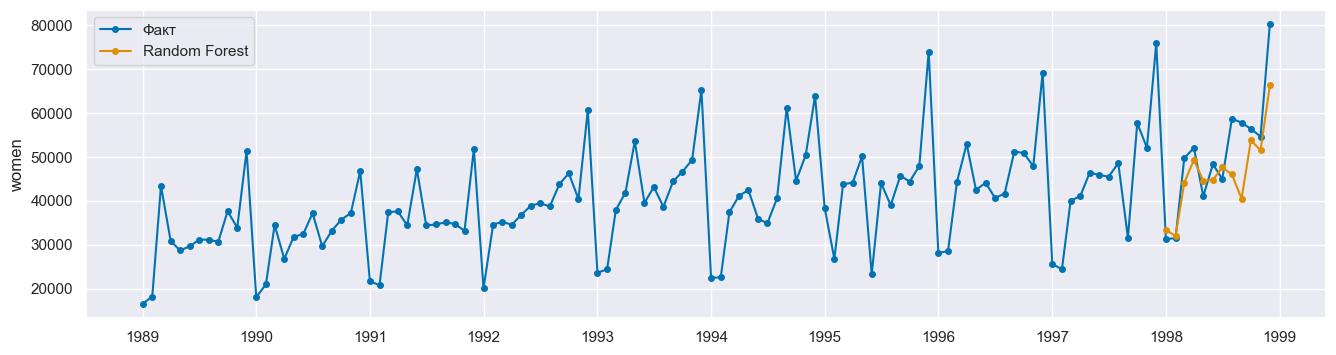

In [52]:
plot_series(w, w_f_rf, labels=['Факт', 'Random Forest'])
plt.show()

In [66]:
w_metrics_rf = metrics('Random Forest авторегрессия', w_test, w_f_rf)
w_metrics_rf

,model,mape,rmse,bias
1,Random Forest авторегрессия,0.104988,7897.113199,4400.493175


**xgboost**

Аналогично можно получить прогноз по дргуой модели - xgboost (может потребоваться установка пакета `xgboost` через conda или pip)

In [64]:
# Шаг 1 - импорт и создание модели
from xgboost import XGBRegressor
regressor = XGBRegressor(objective='reg:squarederror', random_state=4224)
forecaster = make_reduction(regressor, strategy="recursive", window_length=24)
# Шаг 2 - горизонт (тот же самый)
# Шаг 3 - обучение:
forecaster.fit(w_train)
# Шаг 4 - прогнозирование
w_f_xgboost = forecaster.predict(fh)

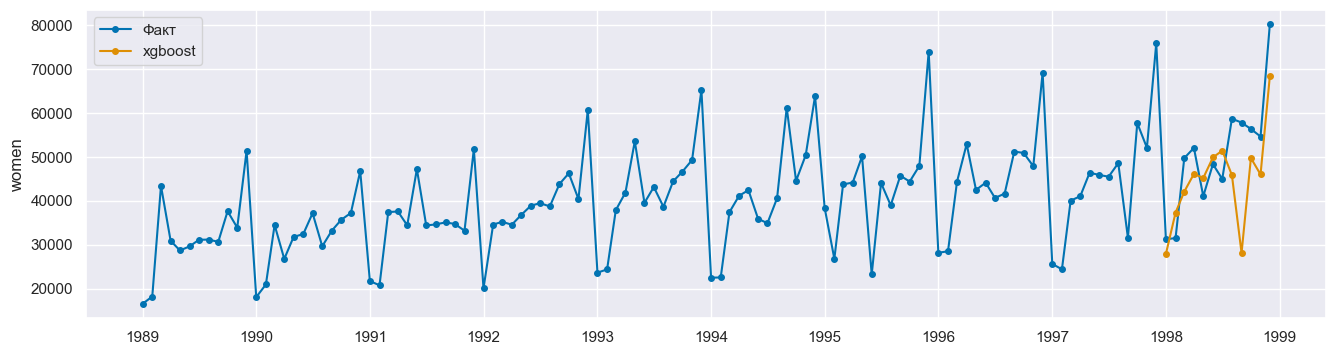

In [65]:
plot_series(w, w_f_xgboost, labels=['Факт', 'xgboost'])
plt.show()

In [69]:
w_metrics_xgboost = metrics('xgboost авторегрессия', w_test, w_f_xgboost)
w_metrics_xgboost

,model,mape,rmse,bias
1,xgboost авторегрессия,0.1656,11182.541794,5706.980547


## Модели с факторами

Для прогнозирования можно использовать не прошлые значения, а внешние факторы (цены, промо-активности, календарь и т.п.). 
Значения факторов должны быть доступны как для исторического, так и для будущего периода.

Для подготовки данных используем столбец `women` в качестве целевой переменной, и столбцы `mail...service` в качестве факторов.

In [115]:
y = catalog['women']
X = catalog[['mail', 'page', 'phone', 'printadv', 'service']]

Обогатим данные информацией о месяце продаж, закодировав месяц набором фиктивных переменных.

In [116]:
X['month'] = X.index.month.astype('category').copy()
X = pd.get_dummies(X, drop_first=True)
X.head()

C:\Users\bitopfer\AppData\Local\Temp\ipykernel_40984\861506447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = X.index.month.astype('category').copy()


,mail,page,phone,printadv,service,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1989-01,7978,73,34,22294.48,20,False,False,False,False,False,False,False,False,False,False,False
1989-02,8290,88,29,27426.47,20,True,False,False,False,False,False,False,False,False,False,False
1989-03,8029,65,24,27978.66,26,False,True,False,False,False,False,False,False,False,False,False
1989-04,7752,85,20,28949.65,22,False,False,True,False,False,False,False,False,False,False,False
1989-05,8685,74,17,22642.27,21,False,False,False,True,False,False,False,False,False,False,False


Нужно заново разбить данные на обучающий и тестовый периоды, чтобы добавить данные о факторах.

In [118]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=12)

In [119]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [120]:
# Define and train the model
regressor = RandomForestRegressor(n_estimators=100, random_state=2442)
forecaster = make_reduction(regressor, window_length=24, strategy="recursive")
forecaster.fit(y_train, X_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=2442),
                                     window_length=24)

In [121]:
# Generate forecasts
w_f_rf_factors = forecaster.predict(fh, X=X_test)

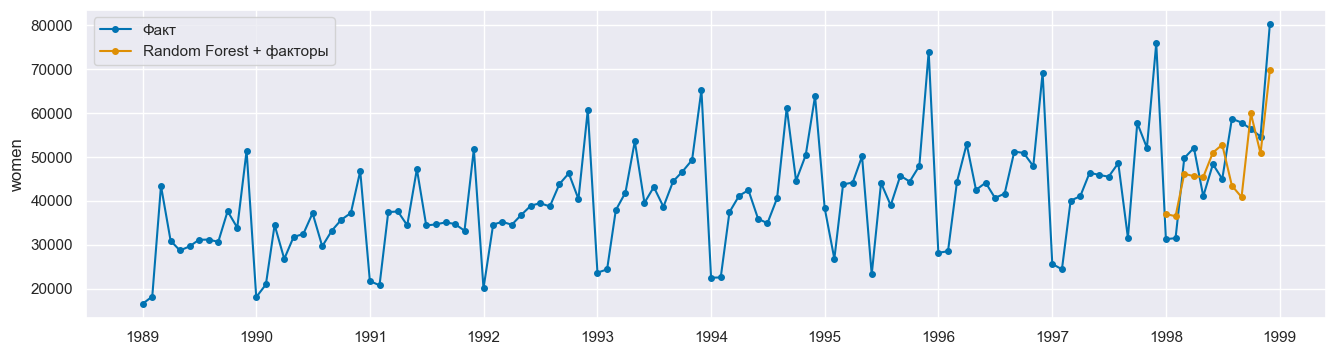

In [122]:
plot_series(w, w_f_rf_factors,
            labels=['Факт', 'Random Forest + факторы'])
plt.show()

In [123]:
w_metrics_rf_factors = metrics('Random Forest + факторы', y_test, w_f_rf_factors)
w_metrics_rf_factors

,model,mape,rmse,bias
1,Random Forest + факторы,0.140703,8443.913819,2291.4194


## Сравнение моделей

In [124]:
pd.concat(
    [w_metrics_naive, w_metrics_winters_mult, w_metrics_autoETS, w_metrics_rf, w_metrics_xgboost, w_metrics_rf_factors]
).sort_values(by='mape', ascending=True)

,model,mape,rmse,bias
1,Auto ETS,0.093770,6456.411862,3799.198346
1,Винтерс (мультипликативная сезонность),0.103493,6553.103354,3798.889652
1,Random Forest авторегрессия,0.104988,7897.113199,4400.493175
1,Random Forest + факторы,0.140703,8443.913819,2291.419400
1,naive,0.146223,9780.764538,5992.535833
1,xgboost авторегрессия,0.165600,11182.541794,5706.980547


В sktime можно сравнивать модели с помощью кросс-валидации со скользящим окном
![](https://www.sktime.net/en/stable/_images/examples_03b_forecasting_transformers_pipelines_tuning_29_0.png)
![](https://www.sktime.net/en/stable/_images/examples_03b_forecasting_transformers_pipelines_tuning_28_0.png)

In [36]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

Новый горизонт прогнозирования

In [126]:
fh_cv = np.arange(1, 13)
fh_cv

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [136]:
cv = ExpandingWindowSplitter(step_length=1, fh=fh_cv,  initial_window=60)

In [137]:
forecaster = ExponentialSmoothing(trend="add", seasonal="mul", initialization_method='heuristic', sp=12)

df_winters_mult = evaluate(
    forecaster=forecaster, y=w_train, cv=cv, strategy="refit", return_data=True
)

In [138]:
df_winters_mult.head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.193342,0.060095,0.005006,60,1993-12,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-01 22513.18 1994-02 22573.29 1...,1994-01 25844.265645 1994-02 31301.83293...
1,0.189433,0.064955,0.005474,61,1994-01,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-02 22573.29 1994-03 37414.13 1...,1994-02 30813.290237 1994-03 44477.24089...
2,0.150822,0.056221,0.004803,62,1994-02,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-03 37414.13 1994-04 41151.05 1...,1994-03 42997.589657 1994-04 41233.11996...
3,0.130075,0.056304,0.004944,63,1994-03,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-04 41151.05 1994-05 42418.67 1...,1994-04 40589.638249 1994-05 44728.04553...
4,0.133991,0.057644,0.004877,64,1994-04,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-05 42418.67 1994-06 35911.73 1...,1994-05 44802.484783 1994-06 45717.02522...


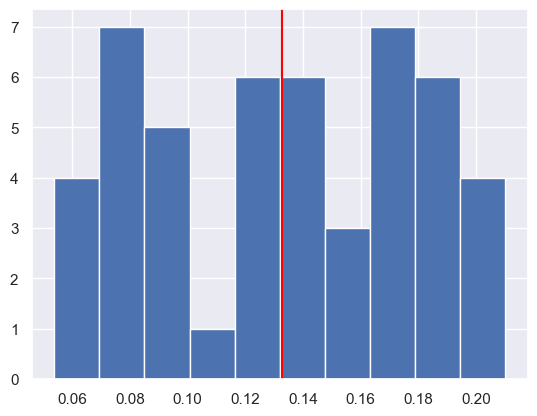

In [44]:
df_winters_mult['test_MeanAbsolutePercentageError'].hist()
plt.axvline(df_winters_mult['test_MeanAbsolutePercentageError'].mean(), color='red')
plt.show()

In [139]:
forecaster = NaiveForecaster(strategy="last", sp=12)
df_naive = evaluate(
    forecaster=forecaster, y=w_train, cv=cv, strategy="refit", return_data=True
)
df_naive.head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.097749,0.002067,0.025610,60,1993-12,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-01 22513.18 1994-02 22573.29 1...,1994-01 23663.65 1994-02 24400.76 1994-0...
1,0.127874,0.002741,0.023169,61,1994-01,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-02 22573.29 1994-03 37414.13 1...,1994-02 24400.76 1994-03 37879.20 1994-0...
2,0.134277,0.001861,0.023511,62,1994-02,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-03 37414.13 1994-04 41151.05 1...,1994-03 37879.20 1994-04 41884.14 1994-0...
3,0.145271,0.001794,0.022022,63,1994-03,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-04 41151.05 1994-05 42418.67 1...,1994-04 41884.14 1994-05 53541.03 1994-0...
4,0.149454,0.001789,0.024078,64,1994-04,date 1989-01 16578.93 1989-02 18236.13 1...,date 1994-05 42418.67 1994-06 35911.73 1...,1994-05 53541.03 1994-06 39528.52 1994-0...


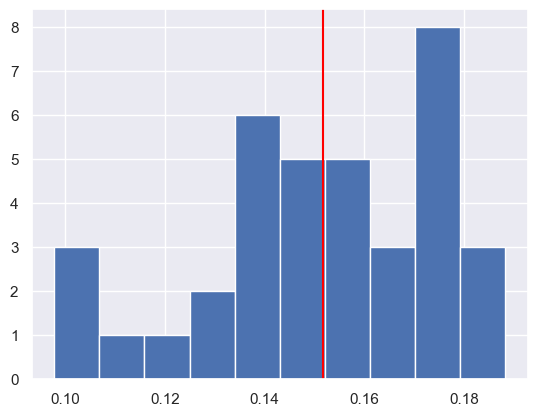

In [140]:
df_naive['test_MeanAbsolutePercentageError'].hist()
plt.axvline(df_naive['test_MeanAbsolutePercentageError'].mean(), color='red')
plt.show()